Neste estudo de caso vamos usar o dataset *bank marketing* disponível no [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). O dataset trata de uma campanha de marketing de um banco português que tinha como objetivo fazer os clientes investirem em um tipo de investimento de renda fixa (*term deposit*).

O objetivo aqui é usar modelos de classificação para prever quais clientes farão o investimento.

## Carregando os pacotes necessários

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Manipulação e Visualização de Dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Pré-Processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV

## Leitura e Divisão dos Dados

In [2]:
bank = pd.read_csv("../data/bank-additional-full.csv", sep=";")

In [5]:
bank_features = bank.drop("y", axis=1)
bank_label = bank[["y"]]

In [6]:
bank_X_tr, bank_X_tt, bank_y_tr, bank_y_tt = train_test_split(bank_features, bank_label, test_size=.3, random_state=42)

## Exploração dos Dados

In [7]:
bank_X_tr.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
39075,29,admin.,married,university.degree,no,no,no,cellular,dec,mon,77,3,999,1,failure,-3.0,92.713,-33.0,0.709,5023.5
34855,29,technician,single,university.degree,no,no,no,telephone,may,fri,12,4,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1
7107,45,blue-collar,married,basic.6y,unknown,yes,no,telephone,may,thu,277,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
31614,34,services,married,university.degree,no,no,no,cellular,may,thu,70,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1
34878,32,admin.,single,high.school,no,no,no,cellular,may,fri,1181,9,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1


In [8]:
bank_X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28831 entries, 39075 to 15795
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp.var.rate    28831 non-null  float64
 16  cons.price.idx  28831 non-null  float64
 17  cons.conf.idx   28831 non-n

Temos então 21 variáveis. sendo `y` a variável dependente. Além disso cabe notar que não temos nenhuma variável com valores nulos, então não será necessário utilizar algum método de imputação.

### Análise Univariada

In [9]:
bank_y_tr["y"].value_counts() / len(bank_y_tr)

no     0.887239
yes    0.112761
Name: y, dtype: float64

Podemos perceber também que é uma base desbalanceada: cerca de 11% da categoria positiva na variável dependente. Um classificador que prevê somente "no" nos daria cerca de 88% de acurácia, apesar de ser inútil.

#### Variáveis Numéricas

In [10]:
bank_X_tr.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000,28831.000000
mean,40.011203,257.875134,2.575769,963.215844,0.172592,0.083202,93.577264,-40.515091,3.621599,5167.011880
std,10.450128,260.212911,2.752303,185.077567,0.494338,1.570978,0.579694,4.634864,1.735202,72.542598
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,318.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Pelas estatísticas descritivas, é possível perceber que algumas das variáveis podem ter outliers, tais como `age`, `duration`, `campaign`, `pdays` e `previous`. Nessas variáveis, os valores tendem a estar concentrados com valores de máximos e mínimos discrepantes em relação à média ou percentis das variáveis. Será necessário investigar um pouco essas variáveis.

Vamos plotar essas variáveis para visualizarmos melhor seus padrões.

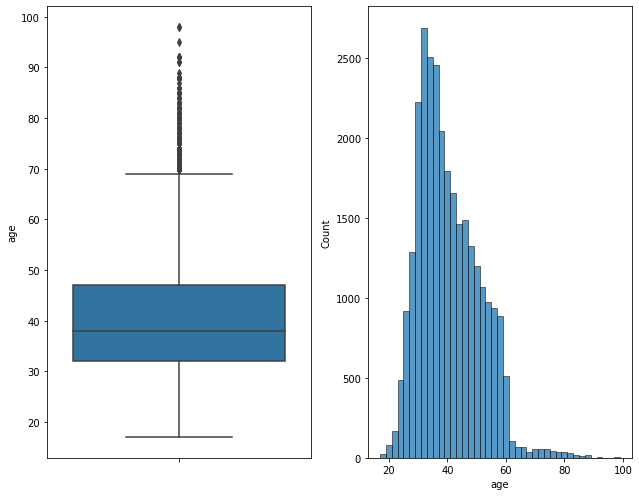

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7))

sns.boxplot(y="age", data=bank_X_tr, ax=ax1)
sns.histplot(x="age", binwidth=2, data=bank_X_tr, ax=ax2)
plt.tight_layout()
plt.show()

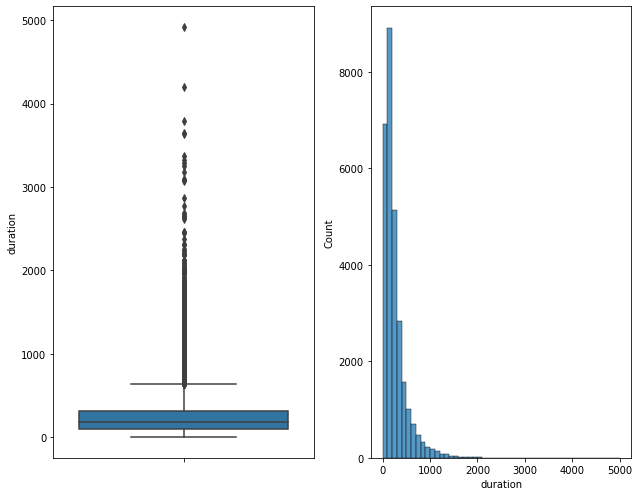

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7))

sns.boxplot(y="duration", data=bank_X_tr, ax=ax1)
sns.histplot(x="duration", binwidth=100,data=bank_X_tr, ax=ax2)
plt.tight_layout()
plt.show()

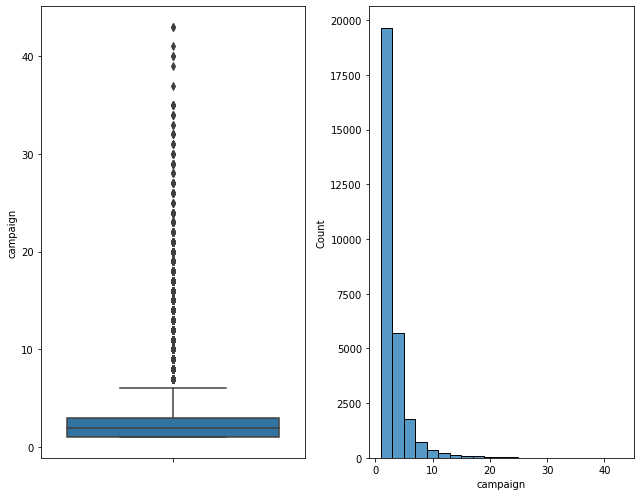

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7))

sns.boxplot(y="campaign", data=bank_X_tr, ax=ax1)
sns.histplot(x="campaign", binwidth=2,data=bank_X_tr, ax=ax2)
plt.tight_layout()
plt.show()

In [14]:
bank_X_tr["pdays"].value_counts().sort_index()

0          9
1         19
2         36
3        308
4         76
5         30
6        295
7         35
8         14
9         38
10        37
11        19
12        40
13        23
14        15
15        19
16         7
17         7
18         5
19         1
20         1
21         1
22         2
25         1
27         1
999    27792
Name: pdays, dtype: int64

In [15]:
np.mean(bank_X_tr["previous"] == 0)

0.8638965002948216

In [16]:
# Transformar em uma dummy: 1 se foi contactado antes e 0 cc
bank_X_tr["previous"].value_counts().sort_index()

0    24907
1     3174
2      531
3      157
4       46
5       12
6        3
7        1
Name: previous, dtype: int64

Alguns destaques:

* Criar versão log de `age`, `campaign`;
* Criar categorias para `pdays` e `previous`: todas as quatro variáveis sofrem com alguns outliers e tendem a estar concentradas em alguns valores;
* A variável `duration` também é concentrada em alguns valores. Mas ela será descartada pois é pouco útil na criação de um modelo realista: só se sabe a duração da ligação uma vez feita a ligação e do cliente decidir ou não pelo investimento. Portanto é uma variável que não dá pra prever *ex-ante*.

#### Variáveis Categoricas

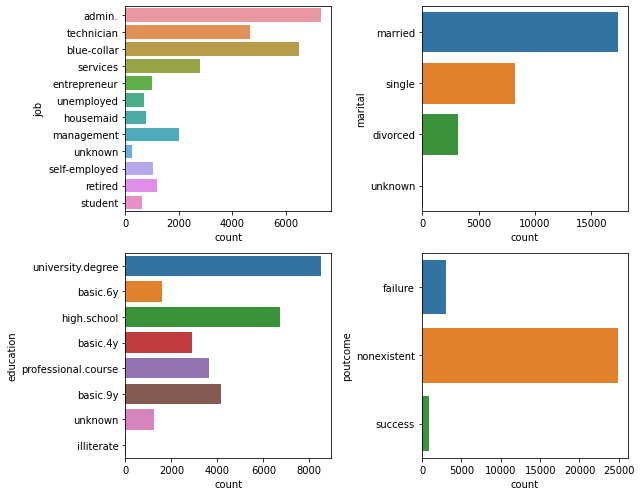

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

sns.countplot(y="job", data=bank_X_tr, ax=axs[0, 0])
sns.countplot(y="marital", data=bank_X_tr, ax=axs[0, 1])
sns.countplot(y="education", data=bank_X_tr, ax=axs[1, 0])
sns.countplot(y="poutcome", data=bank_X_tr, ax=axs[1, 1])
plt.tight_layout()
plt.show()

In [18]:
bank_X_tr["marital"].value_counts()

married     17368
single       8189
divorced     3222
unknown        52
Name: marital, dtype: int64

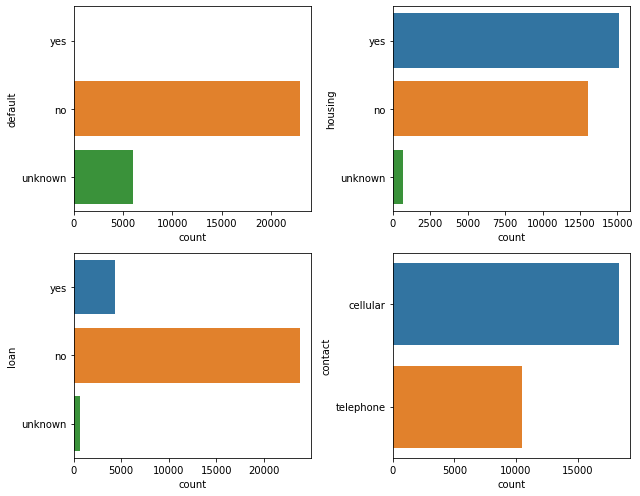

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

sns.countplot(y="default", data=bank_X_tr, ax=axs[0, 0], order=["yes", "no", "unknown"])
sns.countplot(y="housing", data=bank_X_tr, ax=axs[0, 1], order=["yes", "no", "unknown"])
sns.countplot(y="loan", data=bank_X_tr, ax=axs[1, 0], order=["yes", "no", "unknown"])
sns.countplot(y="contact", data=bank_X_tr, ax=axs[1, 1])
plt.tight_layout()
plt.show()

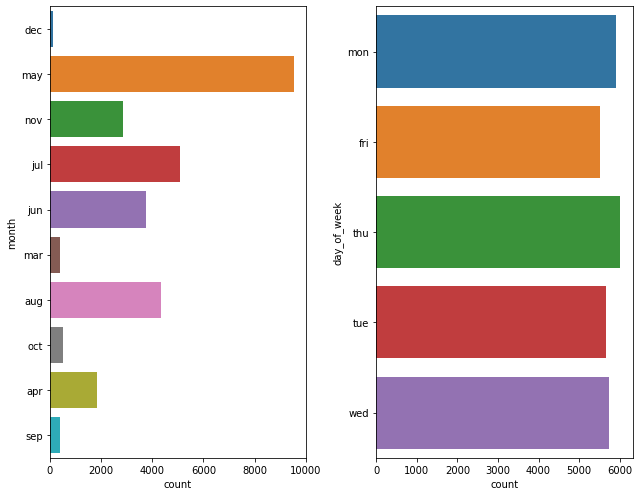

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 7))

sns.countplot(y="month", data=bank_X_tr, ax=axs[0])
sns.countplot(y="day_of_week", data=bank_X_tr, ax=axs[1])
plt.tight_layout()
plt.show()

Conclusões sobre as variáveis categóricas:

* Podemos agregar as categorias em `education` com base se a categoria é de educação primária, secundária ou terciária;
* Em `default` só existem 3 indivíduos para a categoria "yes": vamos criar uma dummy que é 1 se a categoria é "no" e 0 caso contrário;
* Em `month` alguns meses tem poucas observações e outros tem bastante. Vamos testar agregações em trimestres e bimestres para ter categorias mais representativas.

### Análise Bivariada

In [21]:
bank_tr = pd.concat([bank_X_tr, bank_y_tr], axis=1)

In [22]:
bank_X_tr.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.003741,0.008758,-0.036666,0.027094,-0.000595,0.003682,0.126321,0.010074,-0.018042
duration,-0.003741,1.000000,-0.072445,-0.052064,0.020699,-0.029512,0.006035,-0.008210,-0.035028,-0.047273
campaign,0.008758,-0.072445,1.000000,0.050604,-0.077222,0.154406,0.128875,-0.013231,0.138310,0.147386
pdays,-0.036666,-0.052064,0.050604,1.000000,-0.581918,0.267267,0.069794,-0.089671,0.294894,0.373829
previous,0.027094,0.020699,-0.077222,-0.581918,1.000000,-0.418479,-0.199327,-0.054665,-0.452338,-0.498962
emp.var.rate,-0.000595,-0.029512,0.154406,0.267267,-0.418479,1.000000,0.772732,0.191490,0.972088,0.906417
cons.price.idx,0.003682,0.006035,0.128875,0.069794,-0.199327,0.772732,1.000000,0.052215,0.684425,0.517057
cons.conf.idx,0.126321,-0.008210,-0.013231,-0.089671,-0.054665,0.191490,0.052215,1.000000,0.273833,0.098496
euribor3m,0.010074,-0.035028,0.138310,0.294894,-0.452338,0.972088,0.684425,0.273833,1.000000,0.945113
nr.employed,-0.018042,-0.047273,0.147386,0.373829,-0.498962,0.906417,0.517057,0.098496,0.945113,1.000000


#### Variáveis Numéricas

In [23]:
bank_tr.groupby("y").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.927013,220.848006,2.645231,984.756919,0.132643,0.251427,93.605261,-40.601009,3.812835,5176.208432
yes,40.673639,549.217472,2.029222,793.723162,0.486927,-1.240449,93.356977,-39.839065,2.116890,5094.650200


Entre as variáveis numéricas:

* `age` indica que os clientes que fizeram o investimento são em média um ano mais velhos;
* `campaign` indica que os clientes que fizeram o investimento receberam menos ligações em média durante a campanha, ao passo que `pdays` e `previous` indicam que o contato em campanhas anteriores parece ser, na média, um fator importante para a decisão de investimento;
* Entre os indicadores econômicos: decisões por investimento acontecerem, em média, durante períodos em que houve queda na taxa de emprego (`emp.var.rate`), de menores taxas de juros (`euribor3m`), de números menores de emprego (`nr.employed`) e de inflação (`cons.price.idx`) e maior índice de confiança do consumidor (`cons.conf.idx`).

#### Variáveis Categóricas

Vamos tentar plotar duas coisas para cada variável categorica: o numéro de clientes que optaram pelo investimento vs o número de clientes que não optaram pelo investimento, e a porcentagem de clientes em cada categoria que optaram pelo investimento. Para isso, será criada uma função simples para aplicar em cada categoria

In [24]:
def plot_category(df, col):
    df_ = df.copy()
    tab = df_.groupby([col, "y"]).agg(n=("y", lambda x: x.value_counts())).reset_index()
    tab["%"] = tab["n"] / tab.groupby(col)["n"].transform("sum")
    
    fig, axes = plt.subplots(ncols=2, figsize=(9, 7), sharey=True)
    sns.barplot(x="n", y=col, hue="y", data=tab, ax=axes[0])
    sns.barplot(x="%", y=col, data=tab.query("y == 'yes'"), color="#cc8963", ax=axes[1])
    axes[1].set_xlabel("% of 'yes'")
    plt.tight_layout()
    plt.show()

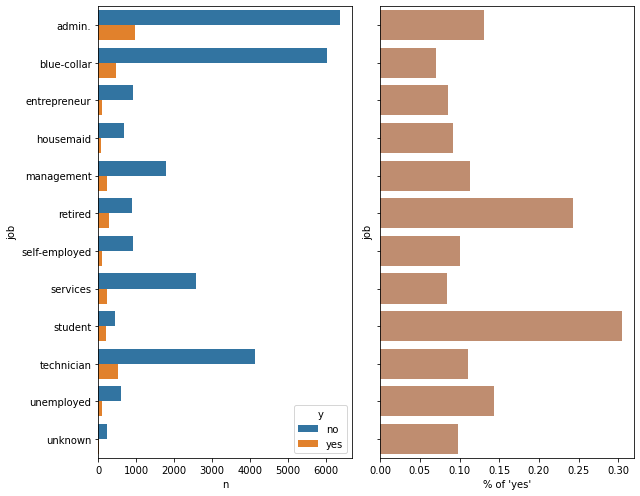

In [25]:
plot_category(bank_tr, "job")

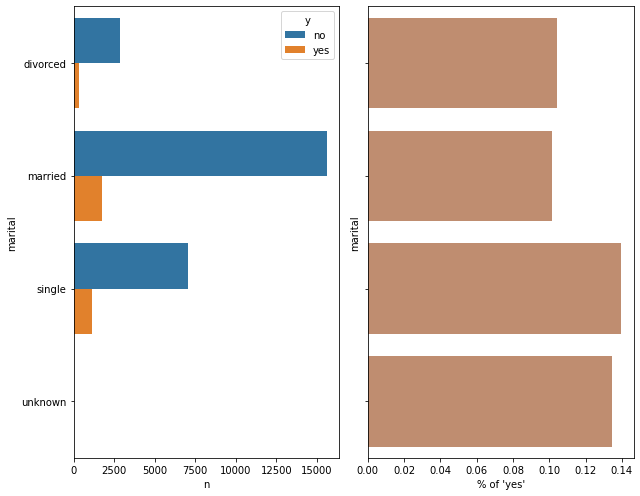

In [26]:
plot_category(bank_tr, "marital")

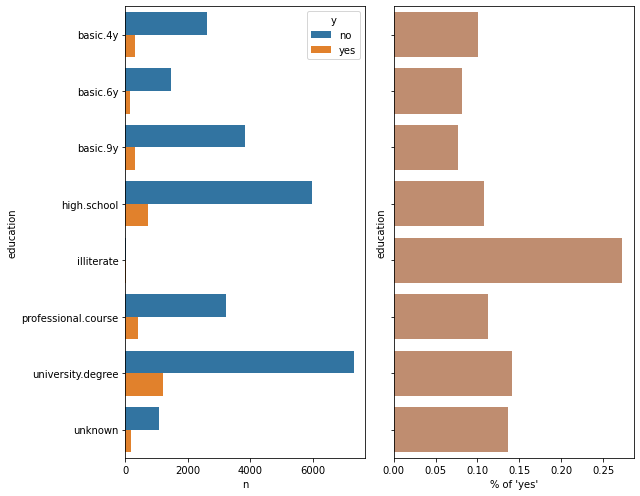

In [27]:
plot_category(bank_tr, "education")

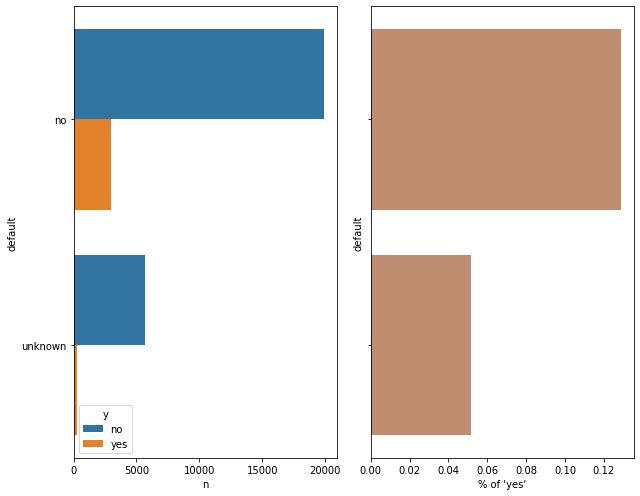

In [28]:
plot_category(bank_tr, "default")

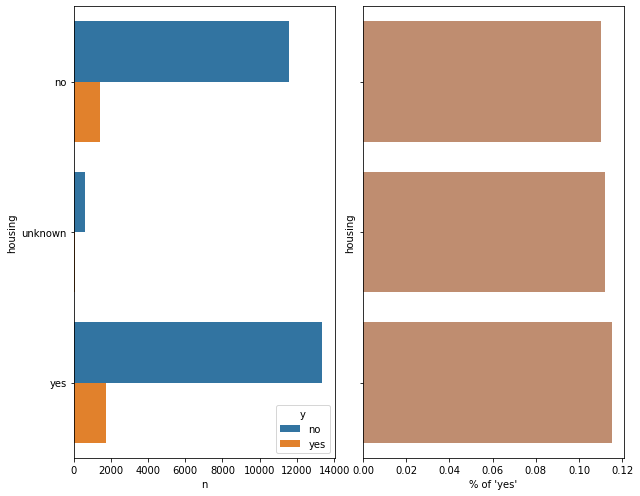

In [29]:
plot_category(bank_tr, "housing")

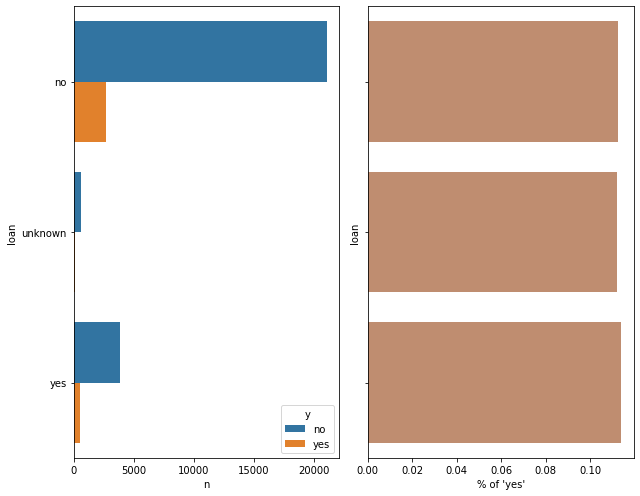

In [30]:
plot_category(bank_tr, "loan")

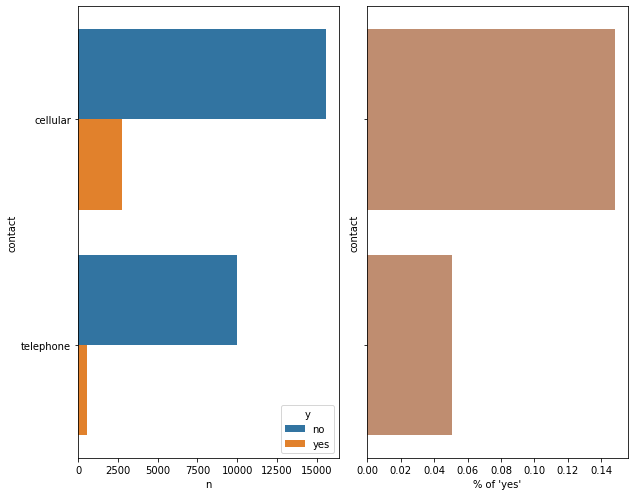

In [31]:
plot_category(bank_tr, "contact")

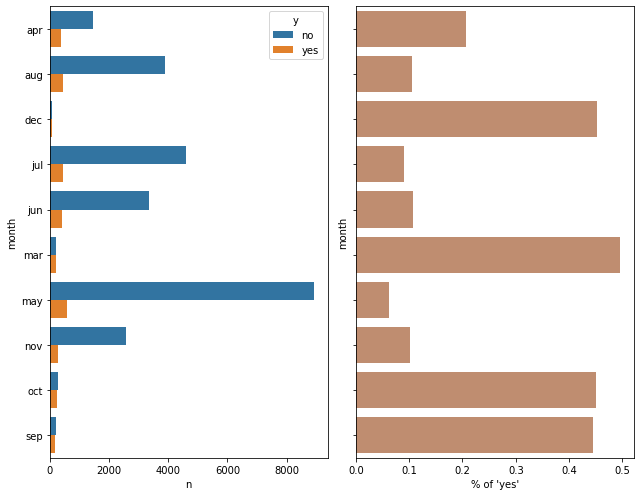

In [32]:
plot_category(bank_tr, "month")

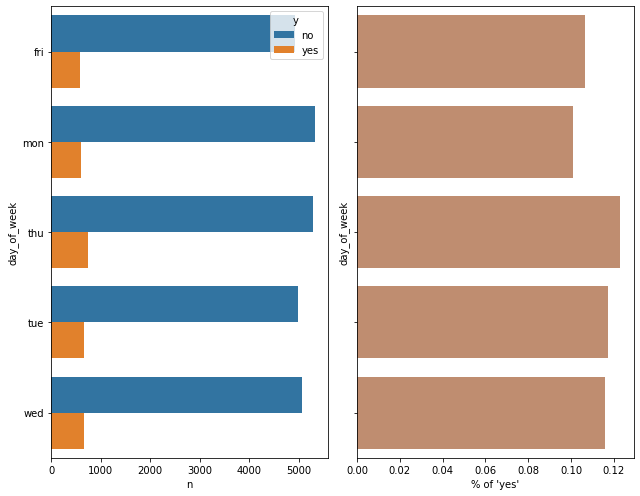

In [33]:
plot_category(bank_tr, "day_of_week")

Alguns destaques:

* Apesar de admin., blue-collar e technician serem a maioria dos clientes em `job`, retired e students são os clientes que proporcionalmente são os que mais optam pelo investimento;
* Em `education`, ilitarates são mais propensos, proporcionalmente, a fazer o investimento. Mas essa categoria é bastante pequena em números absolutos (a ponto de sumir da escala do gráfico), de forma que é dificil concluir que este seja um grupo importante para se focar;
* Em `month` os meses com maior proporção de clientes que optaram pelo investimento também são os meses com menor número de ligações, principalmente em dezembro. Portanto também é difícil que as ligações devem se focar nesses meses.

## Preparando a Base

Com a exploração dos dados, tiramos algumas modificações para algumas variáveis:

* `age`, `campaign`: criar log da variável;
* 
* Criar categorias para `age`, `campaign`, `pdays`, `previous`
* Agregar categorias em `education`;
* Em `default` criar uma dummy só para "no";
* Agregações trimestrais ou bimestrais em `month`.

Para facilitar todas as transformações, vamos criar pipelines no sklearn com o auxílio de transformadores personalizados.

In [179]:
class LogOrQCut(BaseEstimator, TransformerMixin):
    def __init__(self, log_or_qcut="log"):
        self.log_or_qcut = log_or_qcut
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.log_or_qcut == "log":
            return np.log(X)
        
        elif self.log_or_qcut == "qcut":
            quantiles = np.quantile(X, [.25, .5, .75])
            conditions = [
                (X < quantiles[0]),
                (X >= quantiles[0]) & (X < quantiles[1]),
                (X >= quantiles[1]) & (X < quantiles[2]),
                (X >= quantiles[2])
            ]
            
            values = [1, 2, 3, 4]
            
            return np.select(conditions, values)
        
class MonthOrQuarter(BaseEstimator, TransformerMixin):
    def __init__(self, period="monthly"):
        self.period = period
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.period == "monthly":
            monthly = {
                "mar": 1,
                "apr": 2,
                "may": 3,
                "jun": 4,
                "jul": 5,
                "aug": 6,
                "sep": 7,
                "oct": 8,
                "nov": 9,
                "dec": 10
            }
            return X.replace(monthly)
        elif self.period == "quarterly":
            quarterly = {
                "mar": 1,
                "apr": 2,
                "may": 2,
                "jun": 2,
                "jul": 3,
                "aug": 3,
                "sep": 3,
                "oct": 4,
                "nov": 4,
                "dec": 4
            }
            return X.replace(quarterly)

class AggCatVars(BaseEstimator, TransformerMixin):
    def __init__(self, categories, labels):
        self.categories = categories
        self.labels = labels
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for cat, val in zip(self.categories, self.labels):
            X = X.replace(to_replace=cat, value=val)
        return X

In [180]:
educ_categories = [["unknown", "illiterate"],
                   ["basic.4y", "basic.6y", "basic.9y"],
                   ["high.school"],
                   ["professional.course", "university.degree"]]

job_categories = [["blue-collar", "technician", "housemaid"],
                  ["admin.", "management"],
                  ["self-employed", "entrepreneur"]]

vars_orders = [
    ['unknown', 'single', 'married', 'divorced'], #marital
    ["mon", "tue", "wed", "thu", "fri"], #day_of_week
    ["nonexistent", "failure", "success"], #poutcome
    ["unknown", "no", "yes"], #housing
    ["unknown", "no", "yes"] #loan
]

month_order = ["mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]


job_pipeline = Pipeline([
    ("agg_jobs", AggCatVars(categories=job_categories, labels=["manual", "office", "self"])),
    ("oh_jobs", OneHotEncoder())
])

col_transf = ColumnTransformer([
    ("log_or_qcut_age", LogOrQCut(), ["age"]),
    ("log_or_qcut_campaign", LogOrQCut(), ["campaign"]),
    ("oh_pdays", FunctionTransformer(func=lambda x: np.where(x == 999, 0, 1)), ["pdays"]),
    ("oh_previous", FunctionTransformer(func=lambda x: np.where(x >= 1, 1, 0)), ["previous"]),
    ("agg_educ", AggCatVars(categories=educ_categories, labels=[0, 1, 2, 3]), ["education"]),
    ("pipe_job", job_pipeline, ["job"]),
    ("ord_vars", OrdinalEncoder(categories=vars_orders), ["marital", "day_of_week", "poutcome", "housing", "loan"]),
    ("oh_default", FunctionTransformer(func=lambda x: np.where(x == "no", 1, 0)), ["default"]),
    ("oh_contact", OneHotEncoder(), ["contact"]),
    ("ord_month", MonthOrQuarter(), ["month"]),
    ("std_num_vars", StandardScaler(), ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"])
])

label_binarizer = LabelBinarizer()

bank_y_tr_pp = label_binarizer.fit_transform(bank_y_tr).ravel()

Deixamos preparadas as transformações necessárias. Vamos testar alguns modelos e ver qual é os melhores.

## Modelos

Dado a natureza do problema, uma questão é qual métrica utilizar para avaliar os modelos. Já vimos que quase 90% da variável target é da classe negativa, ou sejá, 90% dos individuos no banco não fizeram o investimento. Dado esse nível de imbalanço nos dados, simplesmente utilizar acurácia pode ser problemático (um modelo que sempre prevê "não" como resultado da campanha vai ter acurácia de mais ou menos 90%).

Duas métricas importantes são a Precision e Recall. O primeiro dá a taxa de predições positivas que são verdadeiras (diminui a taxa de falsos positivos), e o segundo é a taxa de indivíduos da classe verdadeira que tiveram predição positiva (diminui a taxa de falsos negativos). O ideal é ter valores altos de Precision e Recall, mas normalmente isso não é possível. Há um trade-off entre as duas taxas e geralmente aumentar a Precision diminui a Recall e vice-versa. O coisa a se pensar então é: qual métrica vai ser mais importante para o nosso problema?

Podemos pensar um pouco sobre custos e benefícios de cada ligação feita para cada cliente. Vamos supor que a decisão de ligar ou não é feita com base na predição positiva feita pelo nosso modelo. 

Ligações incorrem em custos: ao fazer a ligação, o banco terá custos com telefonia, com o treinamento e os salários dos atendentes e etc. Se a ligação for feita para alguém que é pouco provável que fará o investimento, ela será uma ligação que só terá custos, sem nenhum retorno na forma da decisão do investimento para o banco. A métrica de Precision é essencial aqui: desejamos que a maior parte possível de nossas ligações (que, como supomos, foram definidas com base nas predições do modelo) seja para pessoas com chance real de comprar o produto financeiro, diminuindo os custos relativos aos benefícios. Ou seja, desejamos que as ligações sejam focadas ao máximo possível em clientes com alto valor.

Mas há também outra questão aqui. Uma Precision maior equivale a uma Recall menor, e aqui também é interessante uma boa métrica de Recall. Se o objetivo é maximizar os benefícios (em forma de lucros futuros), desejamos não só que a maioria de nossas ligações sejam para clientes de alto valor, desejamos também que nós não deixassemos "passar batido" clientes de alto valor.

No mundo real provavelmente o banco teria algumas estimativas de custos e receitas para cada ligação durante a campanha. Se o custo de uma ligação é baixoar as receitas esperadas com a decisão do cliente de comprar o produto compensar e muito o custo de uma ligação, pode ser interessante aceitar taxas menores de Precision (ou seja, aceitar que a maioria das ligações não seja para pessoas que fariam a compra) com taxas maiores de Recall (Ou seja, garantir que o máximo de clientes que fariam a compra seja contactado).

Seguirei essa suposição então e o modelo final será avaliado com base no Recall.

In [181]:
job_names = col_transf.named_transformers_.pipe_job.named_steps.oh_jobs.get_feature_names_out().tolist()
contact_names = col_transf.named_transformers_.oh_contact.get_feature_names_out().tolist()
cols = ["age", "campaign", "pdays", "previous", "education"] + job_names + ["marital", "day_of_week", "poutcome", "housing", "loan", "default"] + contact_names + ["month", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
len(cols)

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [220]:
# Regressão Logística
lr_pipe = Pipeline([
    ("transf_cols", col_transf),
    ("clf", LogisticRegression(random_state=42, solver="saga"))
])

lr_grid = {
    "transf_cols__log_or_qcut_age__log_or_qcut": ["log", "qcut"],
    "transf_cols__log_or_qcut_campaign__log_or_qcut": ["log", "qcut"],
    "transf_cols__ord_month__period": ["monthly", "quarterly"],
    "clf__penalty": ["l1", "l2", "none"],
    "clf__C": uniform(loc=0, scale=1),
}

lr_clf = RandomizedSearchCV(
    lr_pipe,
    lr_grid,
    cv=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
    n_iter=20
)

# K Neighbors Classifier
knn_pipe = Pipeline([
    ("transf_cols", col_transf),
    ("clf", KNeighborsClassifier())
])

knn_grid = {
    "transf_cols__log_or_qcut_age__log_or_qcut": ["log", "qcut"],
    "transf_cols__log_or_qcut_campaign__log_or_qcut": ["log", "qcut"],
    "transf_cols__ord_month__period": ["monthly", "quarterly"],
    "clf__n_neighbors": np.arange(1, 21),
    "clf__weights": ["uniform", "distance"]
}

knn_clf = RandomizedSearchCV(
    knn_pipe,
    knn_grid,
    cv=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
    n_iter=20
)

# SVC Linear
svc_pipe = Pipeline([
    ("transf_cols", col_transf),
    ("clf", LinearSVC())
])

svc_grid = {
    "transf_cols__log_or_qcut_age__log_or_qcut": ["log", "qcut"],
    "transf_cols__log_or_qcut_campaign__log_or_qcut": ["log", "qcut"],
    "transf_cols__ord_month__period": ["monthly", "quarterly"],
    "clf__penalty": ["l1", "l2"],
    "clf__C": uniform(loc=0, scale=1)
}

svc_clf = RandomizedSearchCV(
    svc_pipe,
    svc_grid,
    cv=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
    n_iter=20
)

# RandomForestClassifier
rf_pipe = Pipeline([
    ("transf_cols", col_transf),
    ("clf", RandomForestClassifier())
])

rf_grid = {
    "transf_cols__log_or_qcut_age__log_or_qcut": ["log", "qcut"],
    "transf_cols__log_or_qcut_campaign__log_or_qcut": ["log", "qcut"],
    "transf_cols__ord_month__period": ["monthly", "quarterly"],
    "clf__n_estimators": [100, 200, 300],
    "clf__min_samples_split": uniform(loc=0, scale=1),
    "clf__min_samples_leaf": uniform(loc=0, scale=1),
    "clf__max_depth": np.arange(1, 11),
    "clf__max_features": uniform(loc=0, scale=1),
}

rf_clf = RandomizedSearchCV(
    rf_pipe,
    rf_grid,
    cv=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
    n_iter=20
)


# GradientBoostingClassifier
gb_pipe = Pipeline([
    ("transf_cols", col_transf),
    ("clf", GradientBoostingClassifier())
])


gb_grid = {
    "transf_cols__log_or_qcut_age__log_or_qcut": ["log", "qcut"],
    "transf_cols__log_or_qcut_campaign__log_or_qcut": ["log", "qcut"],
    "transf_cols__ord_month__period": ["monthly", "quarterly"],
    "clf__n_estimators": [100, 200, 300],
    "clf__subsample": uniform(loc=0, scale=1),
    "clf__min_samples_split": uniform(loc=0, scale=1),
    "clf__min_samples_leaf": uniform(loc=0, scale=1),
    "clf__max_depth": np.arange(1, 11),
    "clf__max_features": uniform(loc=0, scale=1),
}

gb_clf = RandomizedSearchCV(
    gb_pipe,
    gb_grid,
    cv=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
    n_iter=20
)

### Logistic Regression

In [183]:
lr_clf.fit(bank_X_tr, bank_y_tr_pp)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('transf_cols',
                                              ColumnTransformer(transformers=[('log_or_qcut_age',
                                                                               LogOrQCut(),
                                                                               ['age']),
                                                                              ('log_or_qcut_campaign',
                                                                               LogOrQCut(),
                                                                               ['campaign']),
                                                                              ('oh_pdays',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E1721670>),
                                                                               ['pdays']),
                                                                              ('oh_previous',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E157A...
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000149E173D760>,
                                        'clf__penalty': ['l1', 'l2', 'none'],
                                        'transf_cols__log_or_qcut_age__log_or_qcut': ['log',
                                                                                      'qcut'],
                                        'transf_cols__log_or_qcut_campaign__log_or_qcut': ['log',
                                                                                           'qcut'],
                                        'transf_cols__ord_month__period': ['monthly',
                                                                           'quarterly']},
                   random_state=42, scoring='roc_auc')

In [186]:
lr_clf.best_params_

{'clf__C': 0.3745401188473625,
 'clf__penalty': 'l1',
 'transf_cols__log_or_qcut_age__log_or_qcut': 'log',
 'transf_cols__log_or_qcut_campaign__log_or_qcut': 'log',
 'transf_cols__ord_month__period': 'quarterly'}

In [189]:
pd.DataFrame(lr_clf.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_transf_cols__log_or_qcut_age__log_or_qcut,param_transf_cols__log_or_qcut_campaign__log_or_qcut,param_transf_cols__ord_month__period,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.527640,0.432322,0.076995,0.050720,0.37454,l1,log,log,quarterly,"{'clf__C': 0.3745401188473625, 'clf__penalty':...",...,0.777879,0.784117,0.782530,0.801386,0.776005,0.798689,0.790016,0.784574,0.011856,1
18,4.520812,1.151847,0.095946,0.060076,0.520834,l2,qcut,log,quarterly,"{'clf__C': 0.5208342600258237, 'clf__penalty':...",...,0.778341,0.783581,0.783212,0.800926,0.775254,0.798164,0.789526,0.784469,0.011926,2
5,4.749401,1.048597,0.105218,0.058992,0.617482,l2,qcut,log,quarterly,"{'clf__C': 0.6174815096277165, 'clf__penalty':...",...,0.778335,0.783581,0.783239,0.800930,0.775212,0.798121,0.789470,0.784460,0.011923,3
12,1.676018,0.111293,0.061336,0.008800,0.241025,none,qcut,log,quarterly,"{'clf__C': 0.24102546602601171, 'clf__penalty'...",...,0.778302,0.783710,0.783374,0.801061,0.774949,0.798055,0.788878,0.784415,0.011950,4
15,3.197451,0.103530,0.056649,0.005404,0.54671,l2,log,log,quarterly,"{'clf__C': 0.5467102793432796, 'clf__penalty':...",...,0.778273,0.783296,0.783188,0.801070,0.775634,0.798376,0.789120,0.784396,0.011955,5


### K Neighbors

In [190]:
knn_clf.fit(bank_X_tr, bank_y_tr_pp)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('transf_cols',
                                              ColumnTransformer(transformers=[('log_or_qcut_age',
                                                                               LogOrQCut(),
                                                                               ['age']),
                                                                              ('log_or_qcut_campaign',
                                                                               LogOrQCut(),
                                                                               ['campaign']),
                                                                              ('oh_pdays',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E1721670>),
                                                                               ['pdays']),
                                                                              ('oh_previous',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E157A...
                   param_distributions={'clf__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'clf__weights': ['uniform', 'distance'],
                                        'transf_cols__log_or_qcut_age__log_or_qcut': ['log',
                                                                                      'qcut'],
                                        'transf_cols__log_or_qcut_campaign__log_or_qcut': ['log',
                                                                                           'qcut'],
                                        'transf_cols__ord_month__period': ['monthly',
                                                                           'quarterly']},
                   random_state=42, scoring='roc_auc')

In [191]:
knn_clf.best_params_

{'transf_cols__ord_month__period': 'monthly',
 'transf_cols__log_or_qcut_campaign__log_or_qcut': 'qcut',
 'transf_cols__log_or_qcut_age__log_or_qcut': 'qcut',
 'clf__weights': 'uniform',
 'clf__n_neighbors': 15}

In [194]:
pd.DataFrame(knn_clf.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_transf_cols__ord_month__period,param_transf_cols__log_or_qcut_campaign__log_or_qcut,param_transf_cols__log_or_qcut_age__log_or_qcut,param_clf__weights,param_clf__n_neighbors,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.295711,0.019299,0.876357,0.048121,monthly,qcut,qcut,uniform,15,"{'transf_cols__ord_month__period': 'monthly', ...",...,0.762480,0.764839,0.777031,0.796845,0.754798,0.783788,0.754070,0.766416,0.015049,1
8,0.367117,0.057401,1.227917,0.171544,monthly,log,qcut,uniform,16,"{'transf_cols__ord_month__period': 'monthly', ...",...,0.757117,0.769958,0.778373,0.786731,0.752008,0.780357,0.763793,0.766416,0.012958,2
13,0.382876,0.058082,1.209067,0.156367,monthly,log,log,uniform,16,"{'transf_cols__ord_month__period': 'monthly', ...",...,0.758001,0.763388,0.772697,0.789677,0.751978,0.784639,0.761232,0.765518,0.012186,3
9,0.372704,0.061328,1.115916,0.102626,monthly,log,log,uniform,15,"{'transf_cols__ord_month__period': 'monthly', ...",...,0.756505,0.760123,0.770218,0.793583,0.750245,0.787209,0.761879,0.764629,0.014358,4
0,0.288434,0.023042,0.965012,0.183036,quarterly,qcut,qcut,uniform,11,{'transf_cols__ord_month__period': 'quarterly'...,...,0.757514,0.752898,0.762023,0.774648,0.759868,0.769052,0.751950,0.757767,0.009935,5


### Linear SVC

In [197]:
svc_clf.fit(bank_X_tr, bank_y_tr_pp)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('transf_cols',
                                              ColumnTransformer(transformers=[('log_or_qcut_age',
                                                                               LogOrQCut(),
                                                                               ['age']),
                                                                              ('log_or_qcut_campaign',
                                                                               LogOrQCut(),
                                                                               ['campaign']),
                                                                              ('oh_pdays',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E1721670>),
                                                                               ['pdays']),
                                                                              ('oh_previous',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E157A...
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000149E3AE9550>,
                                        'clf__penalty': ['l1', 'l2'],
                                        'transf_cols__log_or_qcut_age__log_or_qcut': ['log',
                                                                                      'qcut'],
                                        'transf_cols__log_or_qcut_campaign__log_or_qcut': ['log',
                                                                                           'qcut'],
                                        'transf_cols__ord_month__period': ['monthly',
                                                                           'quarterly']},
                   random_state=42, scoring='roc_auc')

In [198]:
svc_clf.best_params_

{'clf__C': 0.5467102793432796,
 'clf__penalty': 'l2',
 'transf_cols__log_or_qcut_age__log_or_qcut': 'log',
 'transf_cols__log_or_qcut_campaign__log_or_qcut': 'log',
 'transf_cols__ord_month__period': 'quarterly'}

In [229]:
pd.DataFrame(svc_clf.cv_results_).sort_values("rank_test_score")

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

### RandomForestClassifier

In [221]:
rf_clf.fit(bank_X_tr, bank_y_tr_pp)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('transf_cols',
                                              ColumnTransformer(transformers=[('log_or_qcut_age',
                                                                               LogOrQCut(),
                                                                               ['age']),
                                                                              ('log_or_qcut_campaign',
                                                                               LogOrQCut(log_or_qcut='qcut'),
                                                                               ['campaign']),
                                                                              ('oh_pdays',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E1721670>),
                                                                               ['pdays']),
                                                                              ('oh_previous',
                                                                               FunctionTransformer(func=<function <lambda...
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000149E6240AF0>,
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000149E699E040>,
                                        'clf__n_estimators': [100, 200, 300],
                                        'transf_cols__log_or_qcut_age__log_or_qcut': ['log',
                                                                                      'qcut'],
                                        'transf_cols__log_or_qcut_campaign__log_or_qcut': ['log',
                                                                                           'qcut'],
                                        'transf_cols__ord_month__period': ['monthly',
                                                                           'quarterly']},
                   random_state=42, scoring='roc_auc')

In [222]:
rf_clf.best_params_

{'clf__max_depth': 6,
 'clf__max_features': 0.007066305219717406,
 'clf__min_samples_leaf': 0.023062425041415757,
 'clf__min_samples_split': 0.5247746602583891,
 'clf__n_estimators': 300,
 'transf_cols__log_or_qcut_age__log_or_qcut': 'qcut',
 'transf_cols__log_or_qcut_campaign__log_or_qcut': 'qcut',
 'transf_cols__ord_month__period': 'quarterly'}

In [224]:
pd.DataFrame(rf_clf.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,param_transf_cols__log_or_qcut_age__log_or_qcut,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,3.023614,0.429831,0.221607,0.016502,6,0.007066,0.023062,0.524775,300,qcut,...,0.769678,0.771992,0.771021,0.787363,0.774046,0.785876,0.781624,0.773342,0.009998,1
16,4.292821,1.085389,0.332810,0.168967,10,0.025419,0.107891,0.031429,300,log,...,0.759959,0.767672,0.751873,0.766320,0.763660,0.768462,0.754126,0.759973,0.007286,2
19,4.860403,1.247803,0.178628,0.050523,6,0.456535,0.21844,0.41651,200,log,...,0.730808,0.725485,0.729995,0.712164,0.717191,0.742383,0.719100,0.723746,0.012116,3
2,2.843995,0.287083,0.126163,0.028107,8,0.832443,0.212339,0.181825,100,log,...,0.701848,0.717740,0.701665,0.721581,0.717592,0.723019,0.721429,0.715356,0.009403,4
17,8.719883,1.324124,0.298702,0.121024,4,0.907566,0.249292,0.410383,300,log,...,0.701359,0.704377,0.691129,0.721102,0.695641,0.719023,0.721209,0.709584,0.012602,5
15,2.766503,0.169834,0.252725,0.052598,3,0.760785,0.561277,0.770967,300,log,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,6
14,0.949760,0.084155,0.110406,0.011571,5,0.729606,0.637557,0.887213,100,log,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,6
13,2.396591,0.072896,0.191190,0.020381,7,0.850039,0.449451,0.09541,300,log,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,6
12,3.213407,0.237210,0.236767,0.081373,8,0.729007,0.77127,0.074045,300,qcut,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,6
11,2.626477,0.195496,0.179520,0.009953,1,0.015636,0.423401,0.394882,300,log,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,6


### GradientBoostingClassifier

In [225]:
gb_clf.fit(bank_X_tr, bank_y_tr_pp)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('transf_cols',
                                              ColumnTransformer(transformers=[('log_or_qcut_age',
                                                                               LogOrQCut(),
                                                                               ['age']),
                                                                              ('log_or_qcut_campaign',
                                                                               LogOrQCut(log_or_qcut='qcut'),
                                                                               ['campaign']),
                                                                              ('oh_pdays',
                                                                               FunctionTransformer(func=<function <lambda> at 0x00000149E1721670>),
                                                                               ['pdays']),
                                                                              ('oh_previous',
                                                                               FunctionTransformer(func=<function <lambda...
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000149E699E1F0>,
                                        'clf__n_estimators': [100, 200, 300],
                                        'clf__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000149E623D1C0>,
                                        'transf_cols__log_or_qcut_age__log_or_qcut': ['log',
                                                                                      'qcut'],
                                        'transf_cols__log_or_qcut_campaign__log_or_qcut': ['log',
                                                                                           'qcut'],
                                        'transf_cols__ord_month__period': ['monthly',
                                                                           'quarterly']},
                   random_state=42, scoring='roc_auc')

In [226]:
gb_clf.best_params_

{'clf__max_depth': 2,
 'clf__max_features': 0.3854165025399161,
 'clf__min_samples_leaf': 0.015966252220214194,
 'clf__min_samples_split': 0.230893825622149,
 'clf__n_estimators': 300,
 'clf__subsample': 0.6832635188254582,
 'transf_cols__log_or_qcut_age__log_or_qcut': 'qcut',
 'transf_cols__log_or_qcut_campaign__log_or_qcut': 'log',
 'transf_cols__ord_month__period': 'quarterly'}

In [227]:
gb_pipe.set_params(**gb_clf.best_params_).fit(bank_X_tr, bank_y_tr_pp)

Pipeline(steps=[('transf_cols',
                 ColumnTransformer(transformers=[('log_or_qcut_age',
                                                  LogOrQCut(log_or_qcut='qcut'),
                                                  ['age']),
                                                 ('log_or_qcut_campaign',
                                                  LogOrQCut(), ['campaign']),
                                                 ('oh_pdays',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000149E1721670>),
                                                  ['pdays']),
                                                 ('oh_previous',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000149E157A040>),
                                                  ['previous'...
                                                  MonthOrQuarter(period='quarterly'),
                                                  ['month']),
                                                 ('std_num_vars',
                                                  StandardScaler(),
                                                  ['emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed'])])),
                ('clf',
                 GradientBoostingClassifier(max_depth=2,
                                            max_features=0.3854165025399161,
                                            min_samples_leaf=0.015966252220214194,
                                            min_samples_split=0.230893825622149,
                                            n_estimators=300,
                                            subsample=0.6832635188254582))])

In [230]:
pd.DataFrame(gb_clf.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__max_features,param_clf__min_samples_leaf,param_clf__min_samples_split,param_clf__n_estimators,param_clf__subsample,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5,8.551733,0.619831,0.076994,0.008063,2,0.385417,0.015966,0.230894,300,0.683264,...,0.796897,0.797615,0.796499,0.820052,0.787263,0.807155,0.792213,0.796457,0.012006,1
11,6.182169,0.508805,0.069614,0.018690,3,0.77127,0.074045,0.358466,100,0.91496,...,0.786898,0.790597,0.788300,0.813839,0.783624,0.796871,0.792094,0.789942,0.011015,2
1,2.948617,0.145507,0.084771,0.018476,8,0.333709,0.142867,0.650888,100,0.96991,...,0.777853,0.785952,0.779547,0.799230,0.776457,0.791490,0.779925,0.781891,0.009088,3
13,2.583690,0.151698,0.070712,0.013524,3,0.472215,0.119594,0.713245,100,0.72173,...,0.771034,0.775397,0.774698,0.790609,0.771722,0.784018,0.770406,0.774026,0.008764,4
10,6.806001,0.404112,0.089962,0.047883,7,0.423401,0.394882,0.293488,300,0.815461,...,0.674785,0.686361,0.670334,0.680007,0.679952,0.696794,0.682121,0.685276,0.015221,5


## Modelos

### Buscando alguns modelos promissores

A ideia aqui é somente testar alguns modelos comumente utilizados para classificação e pegar os 5 mais promissores, sem nenhum ajuste nos hiperparâmetros. Definirei que um modelo é promissor com base no seu ROC-AUC Score: A ideia é só escolher uns modelos que sejam sejam bons preditores da classe positiva (o que se traduz em maior score).

In [66]:
clfs = [
    lr_clf,
    knn_clf,
    svc_clf,
    rf_clf,
    rf_clf,
    gb_clf
]

In [58]:
clf_name = []
mean_roc_auc_cv = []
sd_roc_auc_cv = []

for clf in clfs:
    m = clf()
    
    m_name = m.__class__.__name__
    
    clf_name.append(m_name)
    m.fit(bank_X_tr_pp, bank_y_tr_pp)
    tr_pred = m.predict(bank_X_tr_pp)
    precision_tr.append(precision_score(bank_y_tr_pp, tr_pred))
    recall_tr.append(recall_score(bank_y_tr_pp, tr_pred))
    
    cv_pre = cross_val_score(m, bank_X_tr_pp, bank_y_tr_pp, scoring="precision", cv=10)
    cv_rec = cross_val_score(m, bank_X_tr_pp, bank_y_tr_pp, scoring="recall", cv=10)
    cv_auc = cross_val_score(m, bank_X_tr_pp, bank_y_tr_pp, scoring="roc_auc", cv=10)
    precision_cv.append(np.mean(cv_pre))
    recall_cv.append(np.mean(cv_rec))    
    roc_auc_score_cv.append(np.mean(cv_auc))
    print(m_name)

LogisticRegression
GaussianNB
KNeighborsClassifier
LinearSVC
DecisionTreeClassifier
RandomForestClassifier
GradientBoostingClassifier


In [59]:
models_df = pd.DataFrame({"name": clf_name, "precision_tr": precision_tr, "recall_tr": recall_tr, "precision_cv": precision_cv, "recall_cv": recall_cv, "roc_auc_score_cv": roc_auc_score_cv})

In [60]:
models_df.sort_values("roc_auc_score_cv", ascending=False)

,name,precision_tr,recall_tr,precision_cv,recall_cv,roc_auc_score_cv
6,GradientBoostingClassifier,0.709076,0.269148,0.669360,0.252848,0.802099
0,LogisticRegression,0.681329,0.214396,0.684482,0.212546,0.783351
3,LinearSVC,0.699764,0.182098,0.701484,0.182095,0.779499
5,RandomForestClassifier,0.982374,0.908643,0.529809,0.305447,0.771345
1,GaussianNB,0.241669,0.698247,0.240775,0.695166,0.757945
2,KNeighborsClassifier,0.730310,0.376500,0.545241,0.273444,0.724898
4,DecisionTreeClassifier,0.996238,0.896032,0.320086,0.328816,0.620975


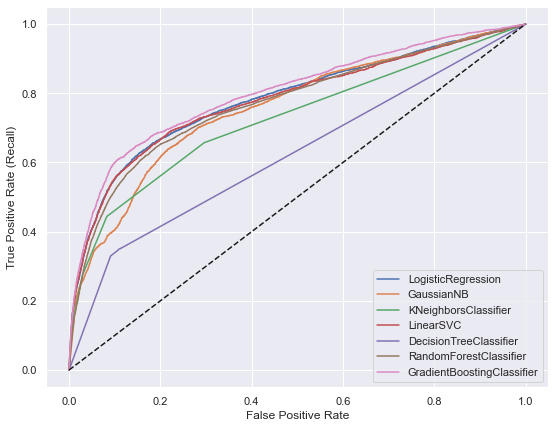

In [61]:
fig, ax = plt.subplots(figsize=(9, 7))

for clf in clfs:
    _clf = clf()
    _clf_name = _clf.__class__.__name__
    
    y_preds = cross_val_predict(_clf, bank_X_tr_pp, bank_y_tr_pp.ravel(), cv = 10, method = "predict_proba" if _clf_name != "LinearSVC" else "decision_function")
    
    fpr, tpr, thresholds = roc_curve(y_true=bank_y_tr_pp, y_score=y_preds[:, 1] if _clf_name != "LinearSVC" else y_preds)
    
    ax.plot(fpr, tpr, label=_clf_name)

ax.plot([0, 1], [0, 1], "k--")
ax.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate (Recall)")
plt.show()

Olhando somente o roc_auc_score feito por cross-validation, os modelos de GradientBoosting, AdaBoost e Logistic Regression parecem ser os três mais promissores. Vamos testar diferentes hiperparâmetros dos três modelos e verificar novamente o roc_auc_score dos melhores modelos entre os três mais promissores.

### GradientBoosting

In [79]:
grad_boost = GradientBoostingClassifier()

params = {
    "loss": ["log_loss", "exponential"],
    "n_estimators": [100, 200, 300],
    "subsample": uniform(loc=0, scale=1),
    "min_samples_split": uniform(loc=0, scale=1),
    "min_samples_leaf": uniform(loc=0, scale=1),
    "max_depth": np.arange(0, 11),
    "max_features": uniform(loc=0, scale=1),
}

gb_clf = RandomizedSearchCV(
    grad_boost, 
    params, 
    cv=10,
    
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
    n_iter=100
)

In [80]:
gb_clf.fit(bank_X_tr_pp, bank_y_tr_pp)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'loss': ['log_loss', 'exponential'],
                                        'max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA7E200A0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA7E20BE0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA76DD640>,
                                        'n_estimators': [100, 200, 300],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CBA76DD7F0>},
                   random_state=42, scoring='roc_auc')

In [67]:
print("ROC-AUC do Melhor Estimador:", gb_clf.best_score_)
gb_clf.best_estimator_

ROC-AUC do Melhor Estimador: 0.8027070883303489


GradientBoostingClassifier(loss='exponential', max_depth=8,
                           max_features=0.6635017691080558,
                           min_samples_leaf=0.005061583846218687,
                           min_samples_split=0.16080805141749865,
                           n_estimators=200, subsample=0.4856137535862266)

Uma melhora bem marginal comparado ao modelo com hiperparâmetros padrões

In [86]:
predicts_gb = cross_val_predict(gb_clf.best_estimator_, bank_X_tr_pp, bank_y_tr_pp.ravel(), cv = 10, method = "predict_proba")

In [94]:
precision_score(bank_y_tr_pp, predicts_gb[:, 1] >= 0.16)

0.4205768402927249

In [95]:
recall_score(bank_y_tr_pp, predicts_gb[:, 1] >= 0.16)

0.6010458320516764

## Testando no Conjunto de Teste

In [96]:
bank_predictions = gb_clf.best_estimator_.predict_proba(bank_X_tt_pp)[:, 1]

In [97]:
precision_score(bank_y_tt_pp, bank_predictions >= 0.16223956223837027)

0.4237644584647739

In [98]:
confusion_matrix(bank_y_tt_pp,  bank_predictions >= 0.16223956223837027)

array([[9872, 1096],
       [ 583,  806]], dtype=int64)

In [75]:
confusion_matrix(bank_y_tt_pp,  bank_predictions >= 0.16223956223837027)

array([[9893, 1075],
       [ 583,  806]], dtype=int64)

In [49]:
custo_total = 1101*2
receita_total = 806*5
receita_total - custo_total

1828

In [77]:
960/(960+429)

0.6911447084233261

In [102]:
feature_importances = pd.DataFrame(data=zip(col_names, gb_clf.best_estimator_.feature_importances_), columns=["feature", "importance"])
feature_importances.sort_values("importance", ascending=False).eval("importance = importance * 100")

,feature,importance
38,nr.employed,38.917025
37,euribor3m,19.235245
2,pdays,11.352106
36,cons.conf.idx,6.918561
33,poutcome_success,5.559827
35,cons.price.idx,2.598499
5,month,2.352509
34,emp.var.rate,1.875889
1,campaign,1.361313
7,day_of_week,1.358204
